# Overall results from these analyses

Results so far looking at two animals (a and b) in two different sessions/areas of A1 (area 1 = session 1, area 2 = session 2)

These graphs/results are all for neuropil data. The results largely hold for F-(FNeu)0.7 data, however animal b shows a negative correlation for fluorescence range versus omission trial order only when looking at neuropil data.

Still analysing 0.5 ISI results.

1. There is no overall increase in dF/F during omission trials when averaging across trials and ROIs
2. There is a significant decrease in dF/F between the start and end of *omission* trials with medium effect size (d = 0.60)
    * Effect also significant in opposite direction for *stimulus* trials (increase in dF/F) but with very small effect size (d = 0.03)
    * Howver, there is no correlation between the size of this difference and the number of trials (it's not driven by specific trials)
3. Early trials appear to show a postive omission response which is not driven by specific ROIs but appears to decline over time
    * I.e., there is a significant negative correlation between dF/F range (max-min) in omission trials and trial order
    * There is no significant effect (or correlation, r approx = 0) for stimulus trials
4. This association between omission trial dF/F range and trial order increases for the second session
    * Less of an effect for animal b, but pronounced if you exclude the last 4 omission trials out of 54 (linear correlation probably not best to capture the trend?)
    * Given the weaker effect for animal b, need to investigate further whether this is a fluke or a real effect
    * Previous work seems to support this as well. E.g., [Gillon et al. (2021)](https://www.biorxiv.org/content/biorxiv/early/2021/01/16/2021.01.15.426915.full.pdf) show that some stimuli take several sessions to show an omission response using calcium imaging of L2/3 and L5 soma+dendrites

In [24]:
import math
from scipy import signal
from scipy import io
from scipy import stats
import scipy.optimize
import scipy.fftpack
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# calculate F/F0
def calc_dF (input):
    input = input - min(input)
    low_pc, high_pc = np.percentile(input, [10, 70])
    filter_arr = np.logical_and(np.greater(input, low_pc), np.less(input, high_pc))
    F0 = np.median(input[filter_arr])
    dF = (input - F0) / F0
    
    return dF

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / math.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def fill_between (x, y, std_err):
    plt.fill_between(x, y+std_err, y-std_err, alpha=0.5)

# Load recordings
#recording_file = 'BGTS_484205_R_IC_area1' # potentially dodgey
#recording_file = 'BGTS_484205_L_IC_area1'
recording_file = 'BGTS_484205_LR'

pupil_stimuli_all = []
pupil_omission_all = []

for recording_file in [
    'IC_BGTS_484205_L_1s_area1', 'IC_BGTS_484205_L_1s_area2',
    'IC_BGTS_484205_R_1s_area1', 'IC_BGTS_484205_R_1s_area2',
    'IC_BGTS_484205_LR_1s_area1', 'IC_BGTS_484205_R_1s_area2'
]:
#for recording_file in ['IC_BGTS_484205_LR_1s_area1']:
    if recording_file == 'A1_GTMK55_1a_1s_area1':
        base_dir = './A1/GTMK55_1a/1s_area1_20210312_13_43_37/plane0/'
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_12_13_43_29.mat')["outDat"]

    elif recording_file == 'A1_GTMK55_1a_1s_area2':
        base_dir = './A1/GTMK55_1a/1s_area2_20210312_14_03_24/'
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_12_14_3_22.mat')["outDat"]

    elif recording_file == 'A1_GTMK55_1b_1s_area1':
        base_dir = './A1/GTMK55_1b/1s_area1_20210312_12_52_22/'
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_12_12_52_12.mat')["outDat"]

    elif recording_file == 'A1_GTMK55_1b_1s_area2':
        base_dir = './A1/GTMK55_1b/1s_area2_20210312_13_13_28/'
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_12_13_12_48.mat')["outDat"]

    elif recording_file == 'IC_BGTS_484204_N_1s_area1':
        base_dir = './IC/BGTS_484204_N/1s_area1_20210322_09_34_14/'
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_22_9_33_50.mat')['outDat']

    elif recording_file == 'IC_BGTS_484205_L_1s_area1':
        base_dir = './IC/BGTS_484205_L/1s_area1_20210323_09_13_34/'
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_23_9_13_26.mat')['outDat'] 
        pupil_area_data = np.load('/home/seb/deeplabcut/pupil-seb-2021-12-03/videos/BGTS_484205_L/pupil_area_blinksremoved.npy')
        pupil_area_data = pupil_area_data[:len(pupil_area_data)//2]

    elif recording_file == 'IC_BGTS_484205_L_1s_area2':
        base_dir = './IC/BGTS_484205_L/1s_area2_20210323_09_55_24/'
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_23_9_55_21.mat')['outDat']
        pupil_area_data = np.load('/home/seb/deeplabcut/pupil-seb-2021-12-03/videos/BGTS_484205_L/pupil_area_blinksremoved.npy')
        pupil_area_data = pupil_area_data[len(pupil_area_data)//2:]

    elif recording_file == 'IC_BGTS_484205_R_1s_area1':
        base_dir = './IC/BGTS_484205_R/1s_area1_20210323_16_00_24/'
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_23_16_0_13.mat')['outDat'] 
        pupil_area_data = np.load('../deeplabcut/pupil-seb-2021-12-03/videos/BGTS_484205_R/pupil_area_blinksremoved.npy')
        pupil_area_data = pupil_area_data[:len(pupil_area_data)//2]
        
    elif recording_file == 'IC_BGTS_484205_R_1s_area2':
        base_dir = './IC/BGTS_484205_R/1s_area1_20210323_16_00_24/' # WRONG
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_23_16_45_39.mat')['outDat'] 
        
        pupil_area_data = np.load('../deeplabcut/pupil-seb-2021-12-03/videos/BGTS_484205_R/pupil_area_blinksremoved.npy')
        pupil_area_data = pupil_area_data[len(pupil_area_data)//2:]

    elif recording_file == 'IC_BGTS_484205_LR_1s_area1':
        base_dir = './IC/BGTS_484205_LR/1s_area1_20210323_12_50_55/'
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_23_12_50_43.mat')['outDat']
        pupil_area_data = np.load('../deeplabcut/pupil-seb-2021-12-03/videos/BGTS_484205_LR/pupil_area_blinksremoved.npy')
        pupil_area_data = pupil_area_data[:len(pupil_area_data)//2]
        
    elif recording_file == 'IC_BGTS_484205_LR_1s_area2':
        base_dir = './IC/BGTS_484205_LR/1s_area1_20210323_12_50_55/' # WRONG
        out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_23_13_48_33.mat')['outDat']
        pupil_area_data = np.load('../deeplabcut/pupil-seb-2021-12-03/videos/BGTS_484205_LR/pupil_area_blinksremoved.npy')
        pupil_area_data = pupil_area_data[len(pupil_area_data)//2:]

    print('Using recordings from file', recording_file)
    
    F = np.load(base_dir + 'F.npy')
    F_neu = np.load(base_dir + 'Fneu.npy')
    
    b_notch, a_notch = signal.iirnotch(w0=2, Q=100, fs=30)
    pupil_area_data = signal.filtfilt(b_notch, a_notch, pupil_area_data)
    
    b_notch, a_notch = signal.iirnotch(w0=4, Q=100, fs=30)
    pupil_area_data = signal.filtfilt(b_notch, a_notch, pupil_area_data)
    
    pupil_area_data_trials = np.reshape(pupil_area_data, (1080, 15))
    

    trial_order = np.array([val[0] for val in out_dat["trialOrder"][0][0]])

    # convert raw fluorescence into deltaF/F
    dF = []
    for i in range(len(F)):
        #dF.append( calc_dF(F[i, :] - 0.7*F_neu[i, :]) )
        dF.append( calc_dF(F_neu[i, :]) )
    dF = np.array(dF)

    # reshape raw data into format (n_ROIs, 30_frames, n_trials)
    # and order into stimuli and omission trials
    n_trials = len(trial_order)
    n_ROIs = len(dF)

    if recording_file.find("0.5ISI") > -1:
        TRIAL_LEN = 15
        TRIAL_PAD = 15
    else:
        TRIAL_LEN = 30
        TRIAL_PAD = 30

        if dF.shape[1] != 32400:
            dF = np.concatenate([dF, np.zeros((588, 14))], axis=1)
    trials_raw = np.reshape(dF[:, :32400], (n_ROIs, TRIAL_LEN, n_trials), order='f')


    # Add padding frames of previous and subsequent trial to each trial
    trials_raw_extended = np.zeros((n_ROIs, 2*TRIAL_PAD+TRIAL_LEN, n_trials))
    for trial_i in range(n_trials):
        if trial_i == 0 or trial_i+1 >= n_trials:
            continue
        else:
            trials_raw_extended[:, :TRIAL_PAD, trial_i] = trials_raw[:, :, trial_i-1]
            trials_raw_extended[:, TRIAL_PAD:TRIAL_PAD+TRIAL_LEN, trial_i] = trials_raw[:, :, trial_i]
            trials_raw_extended[:, TRIAL_PAD+TRIAL_LEN:, trial_i] = trials_raw[:, :, trial_i+1]

    trials_stimuli = []
    trials_omission = []

    pupil_data_stimuli = []
    pupil_data_omission = []

    for i in range(n_trials):
        if i == 0 or i+1 == n_trials or i+2 == n_trials or i+3 == n_trials:
            continue

        trial_id = trial_order[i]
        trial = trials_raw_extended[:, :, i]

        pupil_data = pupil_area_data_trials[i]
        pupil_data_prev = pupil_area_data_trials[i-1]
        pupil_data_next = pupil_area_data_trials[i+1]
        pupil_data_nextn = pupil_area_data_trials[i+2]
        pupil_data_nextnn = pupil_area_data_trials[i+3]

        pupil_data_extended = np.concatenate((
            pupil_data_prev,
            pupil_data,
            pupil_data_next,
            pupil_data_nextn,
            pupil_data_nextnn
        ))
        pupil_data_extended = (pupil_data_extended - np.mean(pupil_data_prev)) / np.std(pupil_data_prev)
        #pupil_data_extended /= pupil_data[0]

        # Remove last and first trials which are just set at 0
        if np.sum(trial) == 0:
            continue

        # Sort into omission trials (id=20)
        if trial_id == 20:
            trials_omission.append(trial)
            pupil_data_omission.append(pupil_data_extended)
        else:
            trials_stimuli.append(trial)
            pupil_data_stimuli.append(pupil_data_extended)

    trials_stimuli = np.transpose(trials_stimuli, [1, 2, 0])
    trials_omission = np.transpose(trials_omission, [1, 2, 0])
    
    pupil_stimuli_all.append(pupil_data_stimuli)
    pupil_omission_all.append(pupil_data_omission)
    
pupil_omission_all = np.concatenate((pupil_omission_all), axis=0)
pupil_stimuli_all = np.concatenate((pupil_stimuli_all), axis=0)
pupil_stimuli_all.shape

Using recordings from file IC_BGTS_484205_L_1s_area1
Using recordings from file IC_BGTS_484205_L_1s_area2
Using recordings from file IC_BGTS_484205_R_1s_area1
Using recordings from file IC_BGTS_484205_R_1s_area2
Using recordings from file IC_BGTS_484205_LR_1s_area1
Using recordings from file IC_BGTS_484205_R_1s_area2


(6133, 75)

### Plot pupil data

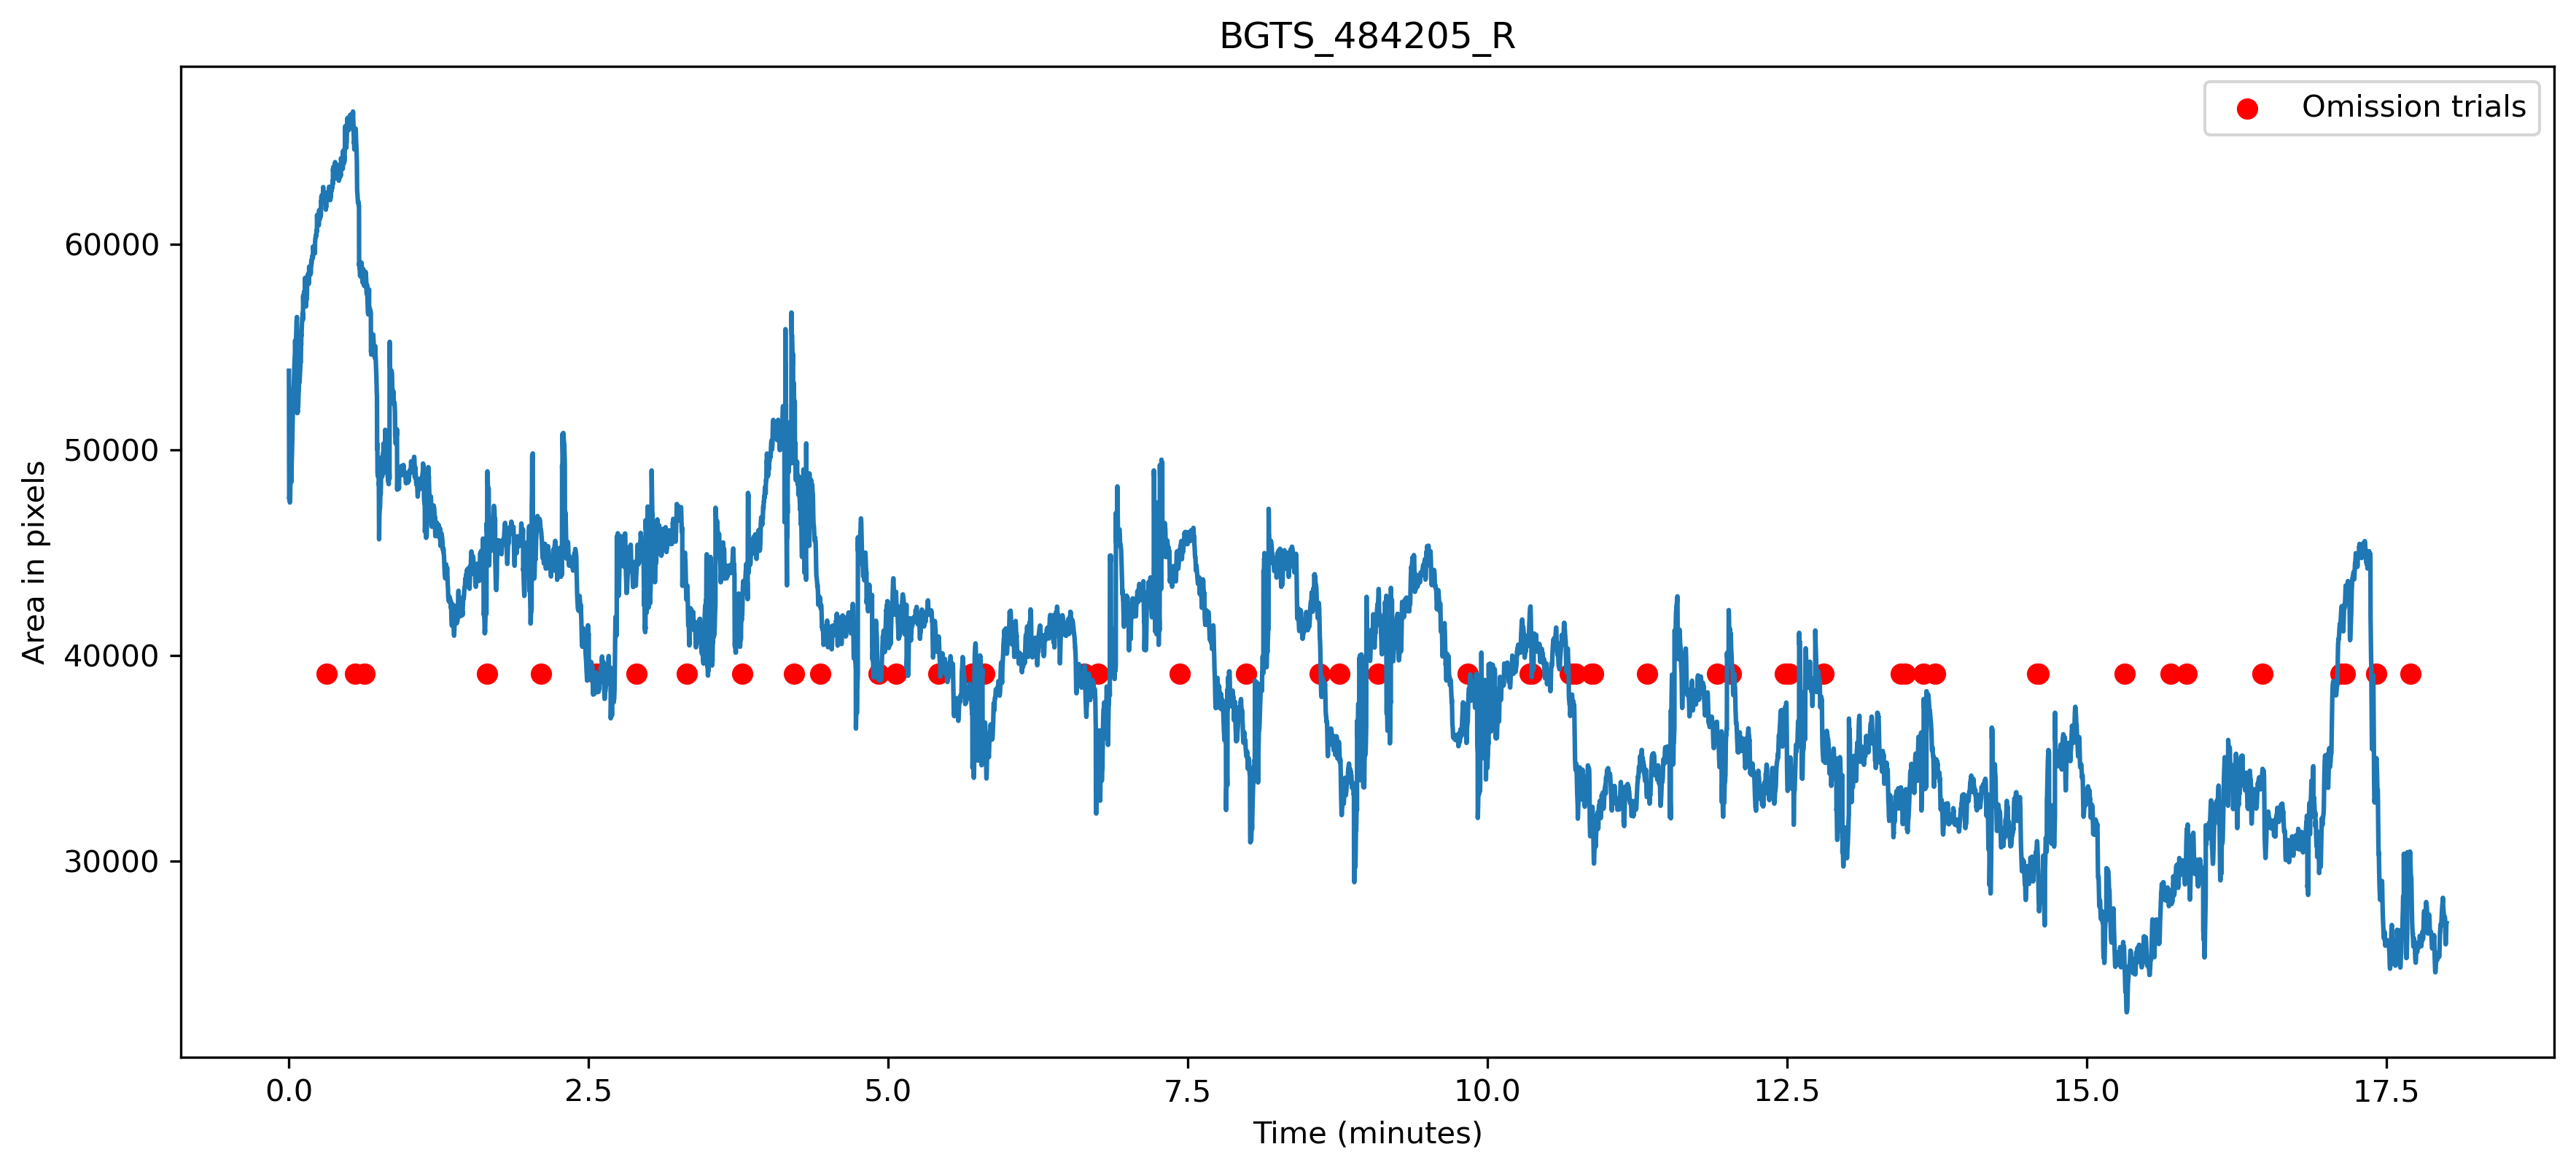

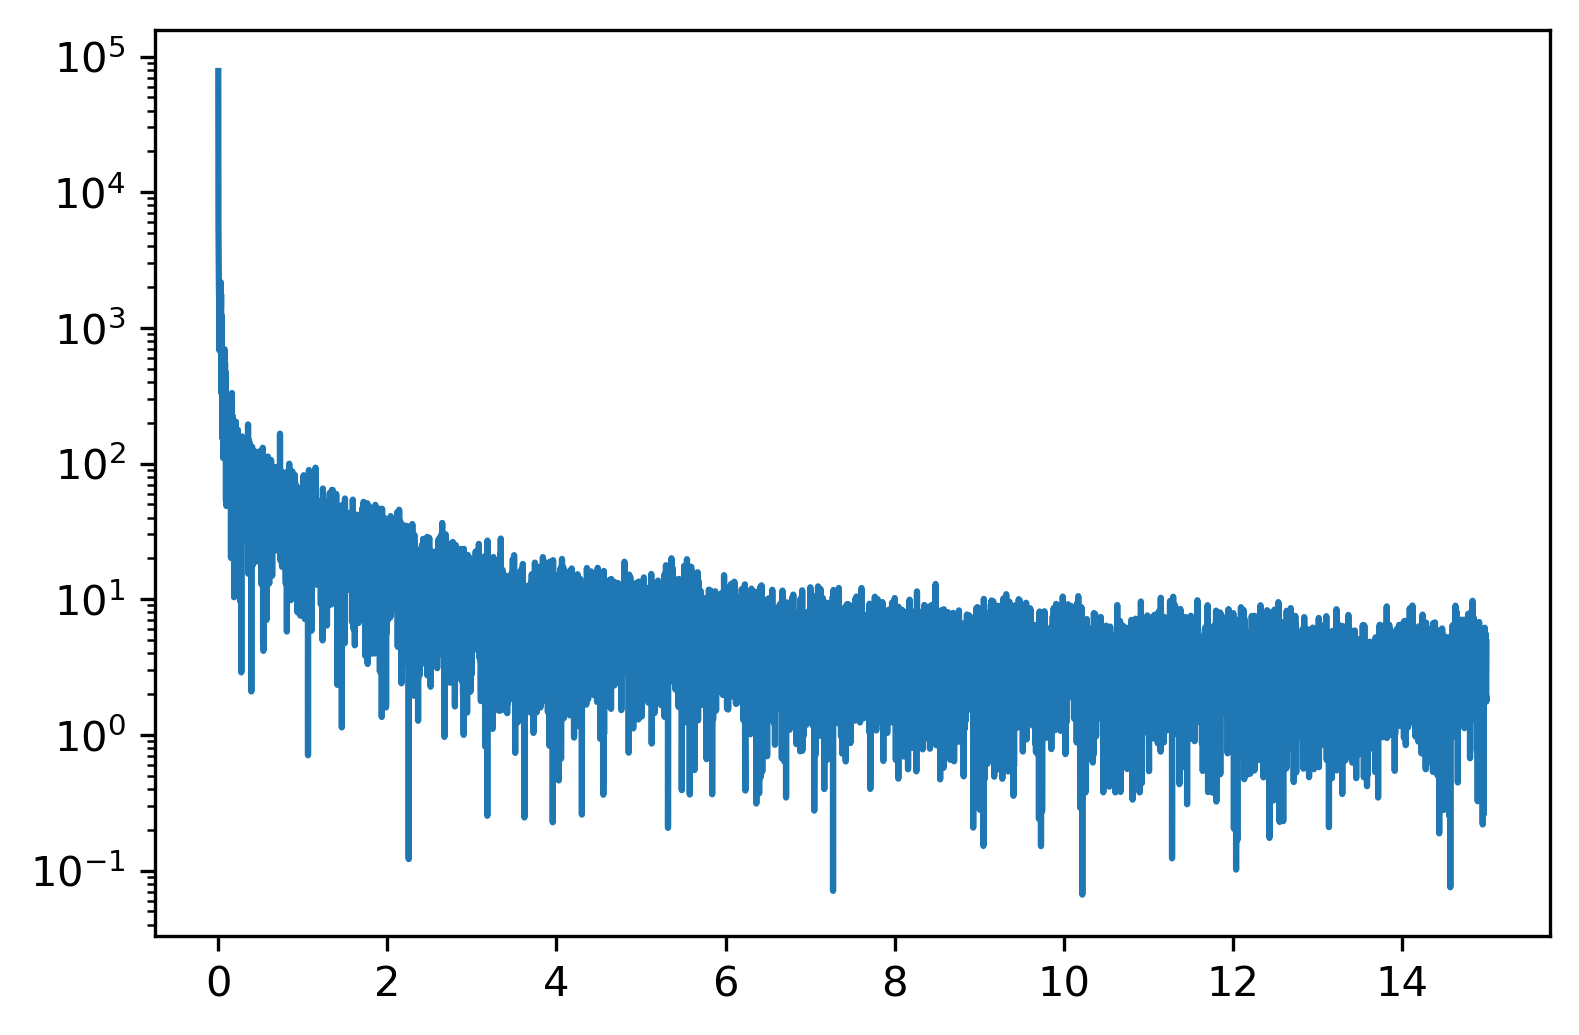

In [17]:
omiss_trials = [idx/60 for idx, n in enumerate(trial_order) if n == 20]

x = np.linspace(0, len(pupil_area_data)*2, len(pupil_area_data)) / (30*60)

fig = plt.figure(dpi=300, figsize=[14, 6])
plt.plot(x, pupil_area_data)
plt.ylabel('Area in pixels')
plt.xlabel('Time (minutes)')
plt.scatter(omiss_trials, np.ones(len(omiss_trials))*np.mean(pupil_area_data), c='red', label='Omission trials')
plt.legend()
plt.title('BGTS_484205_R')
plt.show()

stats.pearsonr(np.arange(len(pupil_area_data))/(30*60), pupil_area_data)

y = pupil_area_data
N = len(y)
T = 1/30
x = np.linspace(0.0, N*T, N)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots(dpi=300)
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.yscale('log')
plt.show()

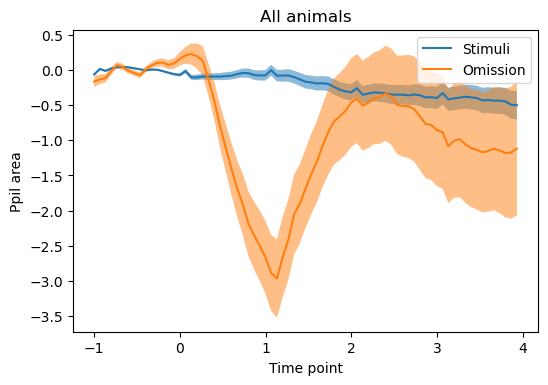

In [25]:
fig = plt.figure(dpi=100)

x = np.arange(-15, 60)/15

mean_pupil_stim = np.mean(pupil_stimuli_all, axis=0)
stderr_pupil_stim = np.std(pupil_stimuli_all, axis=0) / math.sqrt(len(pupil_stimuli_all))

mean_pupil_omission = np.mean(pupil_omission_all, axis=0)
stderr_pupil_omission = np.std(pupil_omission_all, axis=0) / math.sqrt(len(pupil_omission_all))

plt.plot(x, mean_pupil_stim, label='Stimuli')
fill_between (x, mean_pupil_stim, stderr_pupil_stim)
    
plt.plot(x, mean_pupil_omission, label='Omission')
fill_between (x, mean_pupil_omission, stderr_pupil_omission)

plt.legend()
plt.xlabel('Time point')
plt.ylabel('Ppil area')
plt.title('All animals')
plt.show()

In [ ]:
fig = plt.figure(dpi=300)

x = np.arange(-30, 60)

pupil_data_early = pupil_data_omission[:4]
mean_pupil_early = np.mean(pupil_data_early, axis=0)
stderr_pupil_early = np.std(pupil_data_early, axis=0) / math.sqrt(len(pupil_data_early))
    
plt.plot(x, mean_pupil_early, label='Trial n ≤ 4')
fill_between (x, mean_pupil_early, stderr_pupil_early)

pupil_data_middle = pupil_data_omission[4:29]
mean_pupil_middle = np.mean(pupil_data_middle, axis=0)
stderr_pupil_middle = np.std(pupil_data_middle, axis=0) / math.sqrt(len(pupil_data_middle))
    
plt.plot(x, mean_pupil_middle, label='Trial 4 < n < 29')
fill_between (x, mean_pupil_middle, stderr_pupil_middle)

pupil_data_late = pupil_data_omission[29:]
mean_pupil_late = np.mean(pupil_data_late, axis=0)
stderr_pupil_late = np.std(pupil_data_late, axis=0) / math.sqrt(len(pupil_data_late))
    
plt.plot(x, mean_pupil_late, label='Trial n ≥ 29')
fill_between (x, mean_pupil_late, stderr_pupil_late)

plt.legend()
plt.xlabel('Time point')
plt.ylabel('Pupil area')
plt.title('Mean pupil area, normalized to previous trial')
plt.show()

### Remove low response ROIs

In [ ]:
diffs = []
for roi in trials_stimuli:
    roi_trial = roi[TRIAL_PAD:TRIAL_PAD+TRIAL_LEN, :]
    mean_diff = np.mean(np.max(roi_trial, axis=0) - roi_trial[0])

    diffs.append(mean_diff)
    if mean_diff < 0.3:
        plt.plot(np.mean(roi_trial, axis=1))
        plt.show()
    
plt.hist(diffs)

### Matrix of time point by trial number for each ROI

In [ ]:
NORMALIZE = True
    
def scale (x, y):
    min_y = np.reshape(np.min(y, axis=1), (-1, 1))
    max_y = np.reshape(np.max(y, axis=1), (-1, 1))
    
    return (x-min_y)/(max_y-min_y)

# Average across trials ==> (ROIs, time points)
trial_mean_start = np.mean(trials_omission[:, :, :3], axis=2)
trial_mean_middle  = np.mean(trials_omission[:, :, 3:29], axis=2)
trial_mean_end = np.mean(trials_omission[:, :, 29:], axis=2)

# Normalize by first 30 time points
if NORMALIZE:
    trial_mean_start = scale(trial_mean_start, trial_mean_start[:, :30])
    trial_mean_middle = scale(trial_mean_middle, trial_mean_middle[:, :30])
    trial_mean_end = scale(trial_mean_end, trial_mean_end[:, :30])
    
# Set x-axis for all from -30 to +60 
x = np.arange(-TRIAL_PAD, TRIAL_LEN+TRIAL_PAD)

y_start = np.mean(trial_mean_start, axis=0)
yerr_start = np.std(trial_mean_start, axis=0) / math.sqrt(len(trial_mean_start))

y_middle = np.mean(trial_mean_middle, axis=0)
yerr_middle = np.std(trial_mean_middle, axis=0) / math.sqrt(len(trial_mean_middle))

y_end = np.mean(trial_mean_end, axis=0)
yerr_end = np.std(trial_mean_end, axis=0) / math.sqrt(len(trial_mean_end))
    
plt.plot(x, y_start, label='Trial n ≤ 4')
fill_between(x, y_start, yerr_start)
plt.plot(x, y_middle , label='Trial 4 < n < 29')
fill_between(x, y_middle, yerr_middle)
plt.plot(x, y_end , label='Trial n ≥ 29')
fill_between(x, y_end, yerr_end)

#plt.gca().add_patch(
#    Rectangle((0, 0.35), TRIAL_LEN, 0.25, color="grey", alpha=0.125)
#)

plt.xlabel('Time point')
plt.ylabel('dF/F')
plt.legend()
plt.show()

fig = plt.figure(dpi=300)

roi_mean = np.mean(trials_omission[:, :,:], axis=0).T
if NORMALIZE:
    roi_mean = scale(roi_mean, roi_mean[:, :30])

plt.imshow(roi_mean, extent=[-TRIAL_PAD,TRIAL_LEN+TRIAL_PAD,54,0])
plt.ylabel('Trial n')
plt.xlabel('Time point')
plt.colorbar()
plt.show()

fig = plt.figure(dpi=300)


In [ ]:
trial_slice = slice(TRIAL_PAD, TRIAL_PAD+TRIAL_LEN)

start = np.min(trial_mean_start[:, trial_slice], axis=1) 
middle = np.min(trial_mean_middle[:, trial_slice], axis=1) 
end = np.min(trial_mean_end[:, trial_slice], axis=1)

print('start vs middle, p =', stats.ttest_ind(start, middle)[1]*3)
print('start vs end, p =', stats.ttest_ind(start, end)[1]*3)
print('middle vs end, p =', stats.ttest_ind(middle, end)[1]*3)

### What does the mean trial look like if we plot the adjacent trials?

In [ ]:
# Get mean trial for each ROI
mean_trials_stimuli = np.mean(trials_stimuli, axis=2)#, np.ones((1,10)), mode='same')/10
mean_trials_omission = np.mean(trials_omission, axis=2)#, np.ones((1,10)), mode='same')/10

roi_stim_mean = np.mean(mean_trials_stimuli, axis=0)
roi_stim_stderr = np.std(mean_trials_stimuli, axis=0) / math.sqrt(len(mean_trials_stimuli))

roi_omis_mean = np.mean(mean_trials_omission, axis=0)
roi_omis_stderr = np.std(mean_trials_omission, axis=0) / math.sqrt(len(mean_trials_omission))

x = np.arange(-TRIAL_PAD, TRIAL_LEN+TRIAL_PAD) 

plt.plot(x, roi_stim_mean, label='Stimuli')
plt.fill_between(x, roi_stim_mean+roi_stim_stderr, roi_stim_mean-roi_stim_stderr, alpha=0.5)
plt.plot(x, roi_omis_mean, label='Omission')
plt.fill_between(x, roi_omis_mean+roi_omis_stderr, roi_omis_mean-roi_omis_stderr, alpha=0.5)

range_val = np.max(roi_stim_mean)-np.min(roi_stim_mean)
plt.gca().add_patch(
    Rectangle((0, np.min(roi_stim_mean)-range_val*0.5), TRIAL_LEN, range_val*2.5,color="grey", alpha=0.25, label='Trial period')
)

plt.legend(loc=(1.04,0.7))
plt.xlabel('Time')
plt.ylabel('dF/F')

plt.title('Mean across ROIs and across trials')

### Is there low dimensional activity?

In [ ]:
feature_vecs = []

if True:
    rois = np.mean(trials_stimuli, axis=2)
    for time_point in range(TRIAL_LEN):
        fv = rois[:, time_point+TRIAL_PAD]
        feature_vecs.append(fv)
else:
    rois = np.mean(trials_omission, axis=1)
    for trial in range(rois.shape[1]):
        fv = rois[:, trial]
        feature_vecs.append(fv)
    
def center(X):
    ss = StandardScaler(with_mean=True, with_std=False)
    Xc = ss.fit_transform(X.T).T
    return Xc
    
x = np.array(feature_vecs)
x = center(x)
    
pca = PCA(n_components=10)
y = pca.fit_transform(x)

plt.plot(np.arange(1,11), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('N components')
plt.ylabel('Cumulative explained variance')
plt.show()

plt.plot(y[:, 0], label='PC1')
plt.plot(y[:, 1], label='PC2')
plt.plot(y[:, 2], label='PC3')
plt.xlabel('Trial')
plt.ylabel('dF/F')
plt.legend()
plt.show()

pcs = pca.components_
fig = plt.figure(dpi=300)
plt.imshow(pcs)
plt.xlabel('ROI')
plt.ylabel('PC')
plt.show()

### Is there a difference between dF/F at the start and end of omission trials?

In [ ]:
# Get mean trial for each ROI
mean_trials_stimuli = np.mean(trials_stimuli, axis=2)
mean_trials_omission = np.mean(trials_omission, axis=2)

# Now get mean of trial start and end for each ROI
stimuli_start = mean_trials_stimuli[:, TRIAL_PAD]
stimuli_end = mean_trials_stimuli[:, TRIAL_PAD+TRIAL_LEN]
omission_start = mean_trials_omission[:, TRIAL_PAD]
omission_end = mean_trials_omission[:, TRIAL_PAD+TRIAL_LEN]


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8,3], sharey=True)
x_start = np.ones(len(omission_start))+np.random.rand(len(omission_start))*0.5
x_end = np.ones(len(omission_end))*2+np.random.rand(len(omission_end))*0.5
axs[0].scatter(x_start, omission_start, alpha=0.25, label='Start')
axs[0].scatter(1.25, np.mean(omission_start), marker='_', c='blue', linewidth=20)
axs[0].scatter(x_end, omission_end, alpha=0.25, label='End')
axs[0].scatter(2.25, np.mean(omission_end), marker='_', c='red', linewidth=20)
axs[0].set_title('Omission')
axs[0].set_ylabel('dF/F')
axs[0].set_ylim(None, 0.5)
axs[0].set_xticks([])

x_start = np.ones(len(stimuli_start))+np.random.rand(len(stimuli_start))*0.5
x_end = np.ones(len(stimuli_end))*2+np.random.rand(len(stimuli_end))*0.5
axs[1].scatter(x_start, stimuli_start, alpha=0.25, label='Start')
axs[1].scatter(1.25, np.mean(stimuli_start), marker='_', c='blue', linewidth=20)
axs[1].scatter(x_end, stimuli_end, alpha=0.25, label='End')
axs[1].scatter(2.25, np.mean(stimuli_end), marker='_', c='red', linewidth=20)
axs[1].legend()
axs[1].set_title('Stimuli')
axs[1].set_ylabel('dF/F')
axs[1].set_ylim(None, 0.5)
axs[1].set_xticks([])
plt.suptitle('Mean dF/F for first and last time points of each trial')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8,3], sharex=True, sharey=True)
axs[0].hist(omission_start, alpha=0.5, label='Start', density=True)
axs[0].hist(omission_end, alpha=0.5, label='End', density=True)
axs[0].set_title('Omission')
axs[0].set_xlabel('dF/F')

axs[1].hist(stimuli_start, alpha=0.5, label='Start', density=True)
axs[1].hist(stimuli_end, alpha=0.5, label='End', density=True)
axs[1].set_title('Stimuli')
axs[1].legend()
axs[1].set_xlabel('dF/F')
plt.tight_layout()
plt.show()

print('Omission:', stats.ttest_rel(omission_start, omission_end), 'd = ', cohen_d(omission_start, omission_end))
print('Stimuli:', stats.ttest_rel(stimuli_start, stimuli_end), 'd = ', cohen_d(stimuli_start, stimuli_end))

### Do we see a correlation between change in dF/F and the trial order?
I.e., is there a transient decline in calcium levels only for earlier trials which reduces as omissions are repeated (and become less surprising?).

In [ ]:
start_end_diff = []

for roi_idx in range(n_ROIs):
    roi_trials = trials_omission[roi_idx]
    roi_start_end_diff = []
    
    for trial_idx in range(roi_trials.shape[1]):
        trial = roi_trials[:, trial_idx]
        roi_start_end_diff.append(
            trial[TRIAL_PAD] - trial[TRIAL_PAD+TRIAL_LEN]
        )
    start_end_diff.append(roi_start_end_diff)
    
mean_start_end_diff = np.mean(start_end_diff, axis=0)
stderr_start_end_diff = np.std(start_end_diff, axis=0) / math.sqrt(n_ROIs)

x = np.arange(len(mean_start_end_diff))
y = mean_start_end_diff

plt.plot(x, y, label='Trial-wise change in dF/F', c='orange')
plt.fill_between(x, y+stderr_start_end_diff, y-stderr_start_end_diff, alpha=0.5, facecolor='orange')
plt.plot(x, np.ones(len(x))*np.mean(y), label='Mean change in dF/F', c='green')
plt.ylabel('Change in dF/F (start-end)')
plt.xlabel('Trial order (sequential but not adjacent)')
plt.legend()
plt.show()

print("Pearson's r:", stats.pearsonr(x, y))

### Is there anything else going on in earlier trials?

In [ ]:
first_trials_stimuli = trials_stimuli[:, :, 0]
first_trials_omission = trials_omission[:, :, 0]

roi_stim_mean = np.mean(first_trials_stimuli, axis=0)
roi_stim_stderr = np.std(first_trials_stimuli, axis=0) / math.sqrt(len(first_trials_stimuli))

roi_omis_mean = np.mean(first_trials_omission, axis=0)
roi_omis_stderr = np.std(first_trials_omission, axis=0) / math.sqrt(len(first_trials_omission))

x = np.arange(-TRIAL_PAD, TRIAL_PAD+TRIAL_LEN) 

plt.plot(x, roi_stim_mean, label='Stimuli')
plt.fill_between(x, roi_stim_mean+roi_stim_stderr, roi_stim_mean-roi_stim_stderr, alpha=0.5)

plt.plot(x, roi_omis_mean, label='Omission')
plt.fill_between(x, roi_omis_mean+roi_omis_stderr, roi_omis_mean-roi_omis_stderr, alpha=0.5)

plt.gca().add_patch(Rectangle((0, min(roi_stim_mean)-0.025), TRIAL_LEN, max(roi_stim_mean),color="grey", alpha=0.25, label='Trial period'))

plt.legend(loc=(1.04,0.7))
plt.xlabel('Time')
plt.ylabel('dF/F')
#plt.title('F-0.7*FNeu,')
plt.title('Mean across ROIs for first trial')
plt.show()


second_trials_stimuli = trials_stimuli[:, :, 1]
second_trials_omission = trials_omission[:, :, 1]

roi_stim_mean = np.mean(second_trials_stimuli, axis=0)
roi_stim_stderr = np.std(second_trials_stimuli, axis=0) / math.sqrt(len(second_trials_stimuli))

roi_omis_mean = np.mean(second_trials_omission, axis=0)
roi_omis_stderr = np.std(second_trials_omission, axis=0) / math.sqrt(len(second_trials_omission))

plt.plot(x, roi_stim_mean, label='Stimuli')
plt.fill_between(x, roi_stim_mean+roi_stim_stderr, roi_stim_mean-roi_stim_stderr, alpha=0.5)

plt.plot(x, roi_omis_mean, label='Omission')
plt.fill_between(x, roi_omis_mean+roi_omis_stderr, roi_omis_mean-roi_omis_stderr, alpha=0.5)

plt.gca().add_patch(Rectangle((0, min(roi_stim_mean)-0.025), TRIAL_LEN, max(roi_omis_mean),color="grey", alpha=0.25, label='Trial period'))

plt.legend(loc=(1.04,0.7))
plt.xlabel('Time')
plt.ylabel('dF/F')
plt.title('Mean across ROIs for second trial');
plt.show()



last_trials_stimuli = trials_stimuli[:, :, 45]
last_trials_omission = trials_omission[:, :, 45]

roi_stim_mean = np.mean(last_trials_stimuli, axis=0)
roi_stim_stderr = np.std(last_trials_stimuli, axis=0) / math.sqrt(len(last_trials_stimuli))

roi_omis_mean = np.mean(last_trials_omission, axis=0)
roi_omis_stderr = np.std(last_trials_omission, axis=0) / math.sqrt(len(last_trials_omission))

plt.plot(x, roi_stim_mean, label='Stimuli')
plt.fill_between(x, roi_stim_mean+roi_stim_stderr, roi_stim_mean-roi_stim_stderr, alpha=0.5)

plt.plot(x, roi_omis_mean, label='Omission')
plt.fill_between(x, roi_omis_mean+roi_omis_stderr, roi_omis_mean-roi_omis_stderr, alpha=0.5)

plt.legend(loc=(1.04,0.7))
plt.xlabel('Time')
plt.ylabel('dF/F')
plt.title('Mean across ROIs for 45th trial');

### Is this effect driven by individual ROIs?
Looking at the distribution of max-min for trial 1 across ROIs, do we see a few outliers indicating the effect is driven by a few cells

Using range as a proxy for a 'peak' in the calcium signal. However, some trials seem to show an increase at the end of the trial (seemingly prior to next stimulus trial - need to make sure not a bug in the code) which is not really a peak, so may be better thinking of this as reflecting variance or activity

In [ ]:
first_trials_omission = trials_omission[:, :, 0]

roi_omis_max = np.max(first_trials_omission[:, TRIAL_PAD:TRIAL_PAD+TRIAL_LEN], axis=1)
roi_omis_min = np.min(first_trials_omission[:, TRIAL_PAD:TRIAL_PAD+TRIAL_LEN], axis=1)

roi_omis_range = roi_omis_max-roi_omis_min

plt.hist(roi_omis_range, bins=20, facecolor='orange')
plt.xlabel('Max-min dF/F for first trial')
plt.ylabel('Count')
plt.title('Distribution of dF/F range across ROIs for first omission trial')
plt.show()

median = np.median(roi_omis_range)
rois_low = [first_trials_omission[i] for i, roi_range in enumerate(roi_omis_range) if roi_range <= median]
rois_high = [first_trials_omission[i] for i, roi_range in enumerate(roi_omis_range) if roi_range > median]

roi_omis_mean = np.mean(rois_low, axis=0)
roi_omis_stderr = np.std(rois_low, axis=0) / math.sqrt(len(rois_low))
x = np.arange(-TRIAL_PAD, TRIAL_PAD+TRIAL_LEN) 
plt.plot(x, roi_omis_mean, label='Omission', c='orange')
plt.fill_between(x, roi_omis_mean+roi_omis_stderr, roi_omis_mean-roi_omis_stderr, alpha=0.5, facecolor='orange')

plt.gca().add_patch(Rectangle((0, min(roi_omis_mean)-0.025), TRIAL_LEN, max(roi_omis_mean),color="grey", alpha=0.25, label='Trial period'))

plt.legend(loc=(1.04,0.7))
plt.xlabel('Time')
plt.ylabel('dF/F')
#plt.title('F-0.7*FNeu,')
plt.title('FNeu, mean across ROIs for first trial, below median for range')
plt.show()

roi_omis_mean = np.mean(rois_high, axis=0)
roi_omis_stderr = np.std(rois_high, axis=0) / math.sqrt(len(rois_high))
plt.plot(x, roi_omis_mean, label='Omission', c='orange')
plt.fill_between(x, roi_omis_mean+roi_omis_stderr, roi_omis_mean-roi_omis_stderr, alpha=0.5, facecolor='orange')

plt.gca().add_patch(Rectangle((0, min(roi_omis_mean)-0.025), TRIAL_LEN, max(roi_omis_mean),color="grey", alpha=0.25, label='Trial period'))

plt.legend(loc=(1.04,0.7))
plt.xlabel('Time')
plt.ylabel('dF/F')
#plt.title('F-0.7*FNeu,')
plt.title('FNeu, mean across ROIs for first trial, above median for range')
plt.show()


### Does dF/F range correlate with the trial order?
I.e., is this effect reduced for older trials?

In [ ]:
dff_range_stim = []
for roi_idx in range(n_ROIs):
    roi_trials = trials_stimuli[roi_idx]
    roi_dff_range = []
    
    for trial_idx in range(roi_trials.shape[1]):
        trial = roi_trials[:, trial_idx]
        roi_dff_range.append(
            np.max(trial[TRIAL_PAD:TRIAL_LEN]) -
            np.min(trial[TRIAL_PAD:TRIAL_LEN])
        )
    dff_range_stim.append(roi_dff_range)
mean_dff_range_stim = np.mean(dff_range_stim, axis=0)
stderr_dff_range_stim = np.std(dff_range_stim, axis=0) / math.sqrt(n_ROIs)
x_stim = np.arange(len(stderr_dff_range_stim))
y_stim = mean_dff_range_stim

dff_range_omis = []
for roi_idx in range(n_ROIs):
    roi_trials = trials_omission[roi_idx]
    roi_dff_range = []
    
    for trial_idx in range(roi_trials.shape[1]):
        trial = roi_trials[:, trial_idx]
        roi_dff_range.append(
            np.max(trial[TRIAL_PAD:TRIAL_LEN]) -
            np.min(trial[TRIAL_PAD:TRIAL_LEN])
        )
    dff_range_omis.append(roi_dff_range)
mean_dff_range_omis = np.mean(dff_range_omis, axis=0)
stderr_dff_range_omis = np.std(dff_range_omis, axis=0) / math.sqrt(n_ROIs)
x_omis = np.arange(len(stderr_dff_range_omis))
y_omis = mean_dff_range_omis

plt.plot(x_stim, y_stim, label='Stimuli')
plt.fill_between(x_stim, y_stim+stderr_dff_range_stim, y_stim-stderr_dff_range_stim, alpha=0.5)
plt.ylabel('dF/F range')
plt.xlabel('Trial order')
plt.title('Trial-wise dF/F range')
plt.legend()
plt.show()

plt.plot(x_omis, y_omis, label='Omission', c='orange')
plt.fill_between(x_omis, y_omis+stderr_dff_range_omis, y_omis-stderr_dff_range_omis, alpha=0.5, facecolor='orange')
plt.ylabel('dF/F range')
plt.xlabel('Trial order')
plt.title('Trial-wise dF/F range')
plt.legend()
plt.show()

print("Pearson's r stimuli:", stats.pearsonr(x_stim, y_stim))
print("Pearson's r omission:", stats.pearsonr(x_omis, y_omis))

#### It looks like this effect increases with session
Technically these are different areas of auditory cortex within the window but they also occur after each other in time (area 1 = session 1, area 2 = sessio 2)

N.b., hardcoded values here for ease of code

In some conditions last 4 omission trials seemed to obscure overall trend so also with them excluded for interest

In [ ]:
x = [0,1]
x_labels = ['area 1 (session 1)', 'area 2 (session 2)']

y_full_b = [-0.009, -0.03]
y_full_a = [-0.36, -0.68]

y_not_last_4_b = [0.05, -0.30]
y_not_last_4_a = [-0.38, -0.62]

plt.plot(x, y_full_a, label='Animal a')
plt.plot(x, y_full_b, label='Animal b')
plt.xticks(x, x_labels)
plt.ylabel('r coefficient')
plt.xlabel('Session')
plt.legend()
plt.title('All values')
plt.show()

plt.plot(x, y_not_last_4_a, label='Animal a')
plt.plot(x, y_not_last_4_b, label='Animal b')
plt.xticks(x, x_labels)
plt.ylabel('r coefficient')
plt.xlabel('Session')
plt.legend()
plt.title('Last 4 omission trials excluded')
plt.show()